# 🧭 UJIIndoorLoc Reproduction Experiments
This notebook reproduces key results using **k-NN** and **SVM** with optional **PCA** dimensionality reduction on the UJIIndoorLoc WiFi fingerprint dataset.

## 1️⃣ Environment Setup and Dataset Download

In [ ]:
# 1️⃣ Environment Setup + Download UJIIndoorLoc dataset via KaggleHub

!pip install kagglehub --quiet

import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Download dataset from KaggleHub
path = kagglehub.dataset_download("giantuji/UjiIndoorLoc")

print("✅ Dataset downloaded successfully!")
print("📁 Path to dataset files:", path)
print("📄 Files available:", os.listdir(path))

# ✅ Correct file names (case-sensitive)
train_csv = os.path.join(path, "TrainingData.csv")
val_csv = os.path.join(path, "ValidationData.csv")

# Check existence
print("Training file:", train_csv, "exists?", os.path.exists(train_csv))
print("Validation file:", val_csv, "exists?", os.path.exists(val_csv))



100%|██████████| 1.51M/1.51M [00:00<00:00, 107MB/s]

Extracting files...
✅ Dataset downloaded successfully!
📁 Path to dataset files: /root/.cache/kagglehub/datasets/giantuji/UjiIndoorLoc/versions/1
📄 Files available: ['TrainingData.csv', 'ValidationData.csv']
Training file: /root/.cache/kagglehub/datasets/giantuji/UjiIndoorLoc/versions/1/TrainingData.csv exists? True
Validation file: /root/.cache/kagglehub/datasets/giantuji/UjiIndoorLoc/versions/1/ValidationData.csv exists? True


## 2️⃣ Load Data into DataFrames

In [ ]:

df_train = pd.read_csv(train_csv)
print("Train shape:", df_train.shape)
if os.path.exists(val_csv):
    df_val = pd.read_csv(val_csv)
    print("Val shape:", df_val.shape)
else:
    df_val = None


Train shape: (19937, 529)
Val shape: (1111, 529)


## 3️⃣ Preprocessing Helper Functions

In [ ]:

def preprocess_uji_df(df):
    # detect WAP columns
    wap_cols = [c for c in df.columns if c.upper().startswith('WAP')][:520]
    if len(wap_cols) == 0:
        wap_cols = df.columns[:520].tolist()
    X = df[wap_cols].astype(float).copy()
    X = X.replace(100, -110)
    y_building = df['BUILDINGID'].values if 'BUILDINGID' in df.columns else None
    y_floor = df['FLOOR'].values if 'FLOOR' in df.columns else None
    coords = None
    if 'LONGITUDE' in df.columns and 'LATITUDE' in df.columns:
        coords = df[['LONGITUDE','LATITUDE']].values
    return X, y_building, y_floor, coords, wap_cols

X_train_raw, y_train_building, y_train_floor, coords_train, wap_cols = preprocess_uji_df(df_train)
print("X_train_raw shape:", X_train_raw.shape)

if df_val is not None:
    X_val_raw, y_val_building, y_val_floor, coords_val, _ = preprocess_uji_df(df_val)
    print("X_val_raw shape:", X_val_raw.shape)


X_train_raw shape: (19937, 520)
X_val_raw shape: (1111, 520)


## 4️⃣ Scaling and PCA Visualization

# 🧮 Dimensionality Reduction using PCA

With over **520 features (WAPs)**, the dataset is very high-dimensional.
Many WAP signals are weak or redundant, which slows training and increases overfitting risk.

We apply **Principal Component Analysis (PCA)** to:
- Capture the main variance directions in the data.
- Reduce the dimensionality while retaining most of the energy/information.

We will analyze:
- The **explained variance ratio** to decide how many components to retain (typically top 50 as per the paper).
- The **energy plot** of components (similar to Figure 2 in the paper).

PCA-transformed features will be used as input to all models.


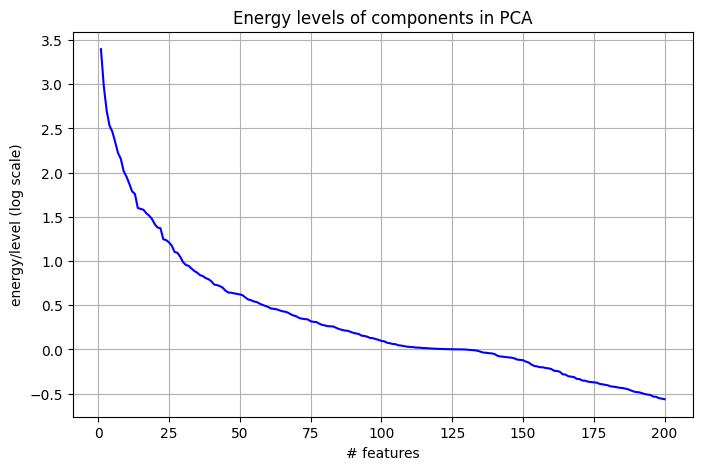

In [ ]:

from sklearn.preprocessing import StandardScaler
def scale_pca(X_train, X_test=None, n_components=200):
    scaler = StandardScaler()
    Xs_train = scaler.fit_transform(X_train)
    Xs_test = scaler.transform(X_test) if X_test is not None else None
    pca = PCA(n_components=n_components, random_state=42)
    Xp_train = pca.fit_transform(Xs_train)
    Xp_test = pca.transform(Xs_test) if Xs_test is not None else None
    return Xp_train, Xp_test, scaler, pca



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_raw)
pca = PCA(n_components=200, random_state=42)
pca.fit(X_scaled)

energy = pca.explained_variance_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(energy)+1), np.log(energy), color='blue')
plt.xlabel("# features")
plt.ylabel("energy/level (log scale)")
plt.title("Energy levels of components in PCA")
plt.grid(True)
plt.show()



## 5️⃣ Model Experiments — k-NN OBS 1:Error vs. Number of Nearest Neighbors (K)

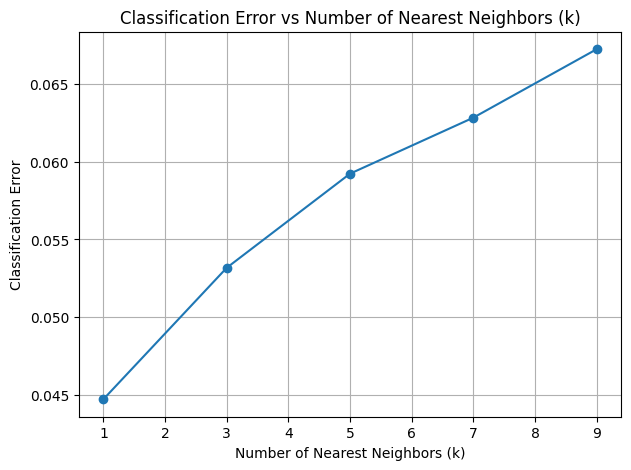

In [ ]:
# 1. Scale and apply PCA to training data
Xp_train, _, scaler, pca = scale_pca(X_train_raw, None, n_components=200)

# 2. Run error vs. k analysis with kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

k_list = [1, 3, 5, 7, 9]
errors = []

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, Xp_train, y_train_floor, cv=10, scoring='accuracy')
    errors.append(1 - np.mean(scores))

plt.figure(figsize=(7,5))
plt.plot(k_list, errors, marker='o')
plt.title("Classification Error vs Number of Nearest Neighbors (k)")
plt.xlabel("Number of Nearest Neighbors (k)")
plt.ylabel("Classification Error")
plt.grid(True)
plt.show()


OBS 2:Effect of Sample Size on Classification Error

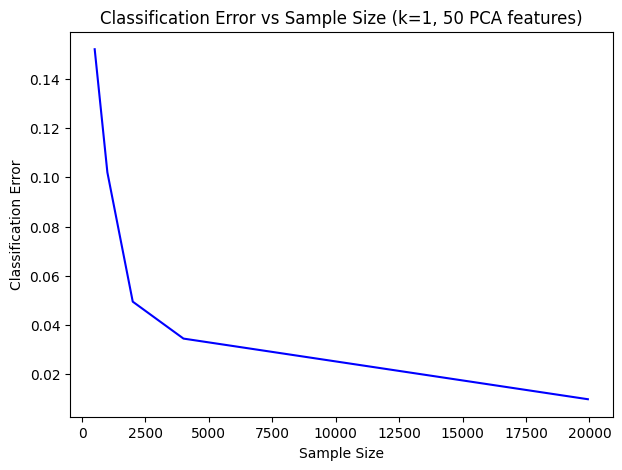

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

sample_sizes = [500, 1000, 2000, 4000, len(X_train_raw)]
errors_size = []

for n in sample_sizes:
    idx = np.random.choice(len(X_train_raw), n, replace=False)
    X_sample = X_train_raw.iloc[idx]
    y_sample = y_train_floor.iloc[idx] if hasattr(y_train_floor, 'iloc') else y_train_floor[idx]
    Xp_sample, _, _, _ = scale_pca(X_sample, None, n_components=50)
    clf = KNeighborsClassifier(n_neighbors=1)
    scores = cross_val_score(clf, Xp_sample, y_sample, cv=5, scoring='accuracy', n_jobs=-1)
    errors_size.append(1 - np.mean(scores))  # Classification error

plt.figure(figsize=(7, 5))
plt.plot(sample_sizes, errors_size, color='blue')
plt.title("Classification Error vs Sample Size (k=1, 50 PCA features)")
plt.xlabel("Sample Size")
plt.ylabel("Classification Error")
plt.show()



In [ ]:
OBS 3:Effect of Number of Principal Features (PCA Components)

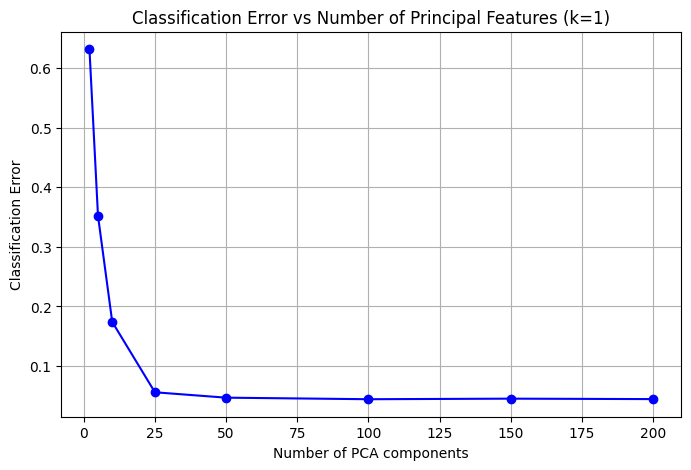

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Define different numbers of PCA components to test
pca_components_list = [2, 5, 10, 25, 50, 100, 150, 200]
errors = []

for n_components in pca_components_list:
    # Scale and apply PCA to training data
    Xp_train, _, _, _ = scale_pca(X_train_raw, None, n_components=n_components)
    # Initialize kNN classifier, k=1 (or choose best k)
    clf = KNeighborsClassifier(n_neighbors=1)
    # 10-fold cross-validation accuracy
    scores = cross_val_score(clf, Xp_train, y_train_floor, cv=10, scoring='accuracy', n_jobs=-1)
    # Append classification error (1 - accuracy)
    errors.append(1 - np.mean(scores))

# Plot error vs PCA components
plt.figure(figsize=(8, 5))
plt.plot(pca_components_list, errors, color='blue', marker='o')
plt.title("Classification Error vs Number of Principal Features (k=1)")
plt.xlabel("Number of PCA components")
plt.ylabel("Classification Error")
plt.grid(True)
plt.show()


In [ ]:
## 6 Model Experiments SVM
OBS1:SVM Error vs Sample Size and Feature Dimensionality (50 vs 150 PCA Components)

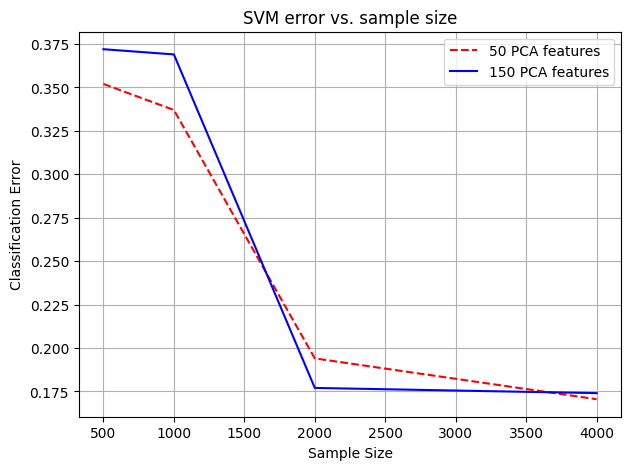

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

sample_sizes = [500, 1000, 2000, 4000]
errors_50 = []
errors_150 = []

for n in sample_sizes:
    idx = np.random.choice(len(X_train_raw), n, replace=False)
    X_sample = X_train_raw.iloc[idx]
    y_sample = y_train_floor.iloc[idx] if hasattr(y_train_floor, 'iloc') else y_train_floor[idx]

    # PCA 50 components
    Xp_50, _, _, _ = scale_pca(X_sample, None, n_components=50)
    svm_50 = SVC(kernel='poly', degree=3)
    scores_50 = cross_val_score(svm_50, Xp_50, y_sample, cv=5, scoring='accuracy', n_jobs=-1)
    errors_50.append(1 - np.mean(scores_50))

    # PCA 150 components
    Xp_150, _, _, _ = scale_pca(X_sample, None, n_components=150)
    svm_150 = SVC(kernel='poly', degree=3)
    scores_150 = cross_val_score(svm_150, Xp_150, y_sample, cv=5, scoring='accuracy', n_jobs=-1)
    errors_150.append(1 - np.mean(scores_150))

plt.figure(figsize=(7, 5))
plt.plot(sample_sizes, errors_50, 'r--', label='50 PCA features')   # Dashed red
plt.plot(sample_sizes, errors_150, 'b-', label='150 PCA features')   # Solid blue
plt.title("SVM error vs. sample size")
plt.xlabel("Sample Size")
plt.ylabel("Classification Error")
plt.legend()
plt.grid(True)
plt.show()


OBS 2:SVM Kernel Comparison (Linear vs Polynomial kernel)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

# Fix sample size and PCA transform for reproducible results
sample_size = 1000
idx = np.random.choice(len(X_train_raw), sample_size, replace=False)
X_sample = X_train_raw.iloc[idx]
y_sample = y_train_floor.iloc[idx] if hasattr(y_train_floor, 'iloc') else y_train_floor[idx]
Xp, _, _, _ = scale_pca(X_sample, None, n_components=150)

# Linear SVM
svm_linear = SVC(kernel='linear')
scores_linear = cross_val_score(svm_linear, Xp, y_sample, cv=5, scoring='accuracy', n_jobs=-1)
acc_linear = np.mean(scores_linear)

# Polynomial SVM with Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}
poly_svm = SVC(kernel='poly')
grid_search = GridSearchCV(poly_svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xp, y_sample)
acc_poly = grid_search.best_score_
best_poly_params = grid_search.best_params_

print("Linear Kernel SVM 5-fold CV Accuracy:", acc_linear)
print("Polynomial Kernel SVM (Tuned) 5-fold CV Accuracy:", acc_poly)
print("Best polynomial kernel parameters:", best_poly_params)


Linear Kernel SVM 5-fold CV Accuracy: 0.9269999999999999
Polynomial Kernel SVM (Tuned) 5-fold CV Accuracy: 0.9570000000000001
Best polynomial kernel parameters: {'C': 1, 'coef0': 1.0, 'degree': 2, 'gamma': 'auto'}


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

def run_tree_experiments(X, y, pca_components_list=[5, 50]):
    """
    Runs experiments for Decision Tree and Gradient Boosting models.
    """
    results = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    print("Running experiments for Decision Tree and Gradient Boosting...")

    for ncomp in pca_components_list:
        print(f"\n=== PCA components: {ncomp} ===")
        Xp, _, _, _ = scale_pca(X, None, n_components=ncomp)

        # Decision Tree Experiment
        dt = DecisionTreeClassifier(random_state=42)
        score_dt = cross_val_score(dt, Xp, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
        print(f"Decision Tree 10-fold CV accuracy: {score_dt:.4f}")
        results.append({'model': 'DecisionTree', 'ncomp': ncomp, 'k': None, 'accuracy': score_dt})

        # Gradient Boosting Experiment
        # The paper finds the optimal number of iterations to be 189
        gb = GradientBoostingClassifier(n_estimators=189, random_state=42)
        score_gb = cross_val_score(gb, Xp, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
        print(f"Gradient Boosting (n=189) 10-fold CV accuracy: {score_gb:.4f}")
        results.append({'model': 'GradientBoosting', 'ncomp': ncomp, 'k': None, 'accuracy': score_gb})

    return pd.DataFrame(results)
# --- Call the function and display the results ---

# Call the function with the training data from earlier cells
df_tree_results = run_tree_experiments(X_train_raw.values, y_train_floor)

# Print the resulting DataFrame to see the accuracy scores
print("\n--- Results ---")
print(df_tree_results)

Running experiments for Decision Tree and Gradient Boosting...

=== PCA components: 5 ===
Decision Tree 10-fold CV accuracy: 0.7712
Gradient Boosting (n=189) 10-fold CV accuracy: 0.7059

=== PCA components: 50 ===
Decision Tree 10-fold CV accuracy: 0.9539
Gradient Boosting (n=189) 10-fold CV accuracy: 0.9711

--- Results ---
              model  ncomp     k  accuracy
0      DecisionTree      5  None  0.771230
1  GradientBoosting      5  None  0.705924
2      DecisionTree     50  None  0.953905
3  GradientBoosting     50  None  0.971058


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import pandas as pd

def run_gb_small_sample_experiment(X, y, n_samples=100, ncomp=50):
    """
    Runs the Gradient Boosting experiment on a small, random subset of the data,
    using the specific parameters from the research paper.
    """
    results = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    print(f"Running Gradient Boosting experiment on {n_samples} samples with {ncomp} PCA components...")

    # 1. Randomly select a subset of the data
    np.random.seed(42) # for reproducibility
    random_indices = np.random.choice(X.shape[0], size=n_samples, replace=False)
    X_sample = X[random_indices]
    y_sample = y[random_indices]

    # 2. Prepare the sampled data with 50 PCA components
    Xp_sample, _, _, _ = scale_pca(X_sample, None, n_components=ncomp)

    # 3. Gradient Boosting Experiment with parameters from the paper
    # n_estimators=189 and max_depth=4
    gb = GradientBoostingClassifier(n_estimators=189, max_depth=4, random_state=42)

    # Evaluate the model on the small sample using 10-fold CV
    score_gb = cross_val_score(gb, Xp_sample, y_sample, cv=cv, scoring='accuracy', n_jobs=-1).mean()

    error_rate = 1 - score_gb
    print(f"\nGradient Boosting (n=189, depth=4) on {n_samples} samples:")
    print(f"  10-fold CV Accuracy: {score_gb:.4f}")
    print(f"  Cross-Validation Error: {error_rate:.4f}")

    results.append({
        'model': f'GradientBoosting_SmallSample',
        'ncomp': ncomp,
        'accuracy': score_gb,
        'error': error_rate
    })

    return pd.DataFrame(results)


# --- Run the small sample experiment ---
df_gb_small_sample_results = run_gb_small_sample_experiment(X_train_raw.values, y_train_floor)

# Display the final result
display(df_gb_small_sample_results)

Running Gradient Boosting experiment on 100 samples with 50 PCA components...

Gradient Boosting (n=189, depth=4) on 100 samples:
  10-fold CV Accuracy: 0.5800
  Cross-Validation Error: 0.4200


,model,ncomp,accuracy,error
0,GradientBoosting_SmallSample,50,0.58,0.42


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import pandas as pd

def run_gb_1000_sample_experiment(X, y, n_samples=1000, ncomp=50):
    """
    Runs the Gradient Boosting experiment on a 1000-sample subset of the data,
    using the specific parameters from the research paper.
    """
    results = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    print(f"Running Gradient Boosting experiment on {n_samples} samples with {ncomp} PCA components...")

    # 1. Randomly select a subset of the data
    np.random.seed(42) # for reproducibility
    random_indices = np.random.choice(X.shape[0], size=n_samples, replace=False)
    X_sample = X[random_indices]
    y_sample = y[random_indices]

    # 2. Prepare the sampled data with 50 PCA components
    Xp_sample, _, _, _ = scale_pca(X_sample, None, n_components=ncomp)

    # 3. Gradient Boosting Experiment with parameters from the paper
    # n_estimators=189 and max_depth=4
    gb = GradientBoostingClassifier(n_estimators=189, max_depth=4, random_state=42)

    # Evaluate the model on the sample using 10-fold CV
    score_gb = cross_val_score(gb, Xp_sample, y_sample, cv=cv, scoring='accuracy', n_jobs=-1).mean()

    error_rate = 1 - score_gb
    print(f"\nGradient Boosting (n=189, depth=4) on {n_samples} samples:")
    print(f"  10-fold CV Accuracy: {score_gb:.4f}")
    print(f"  Cross-Validation Error: {error_rate:.4f}")

    results.append({
        'model': f'GradientBoosting_{n_samples}_samples',
        'ncomp': ncomp,
        'accuracy': score_gb,
        'error': error_rate
    })

    return pd.DataFrame(results)


# --- Run the 1000-sample experiment ---
df_gb_1000_sample_results = run_gb_1000_sample_experiment(X_train_raw.values, y_train_floor)

# Display the final result
display(df_gb_1000_sample_results)

Running Gradient Boosting experiment on 1000 samples with 50 PCA components...

Gradient Boosting (n=189, depth=4) on 1000 samples:
  10-fold CV Accuracy: 0.8950
  Cross-Validation Error: 0.1050


,model,ncomp,accuracy,error
0,GradientBoosting_1000_samples,50,0.895,0.105


Running Pruned Decision Tree experiment with 50 PCA components...
Finding optimal pruning parameter (ccp_alpha) via cross-validation...
Optimal ccp_alpha found: 0.000000


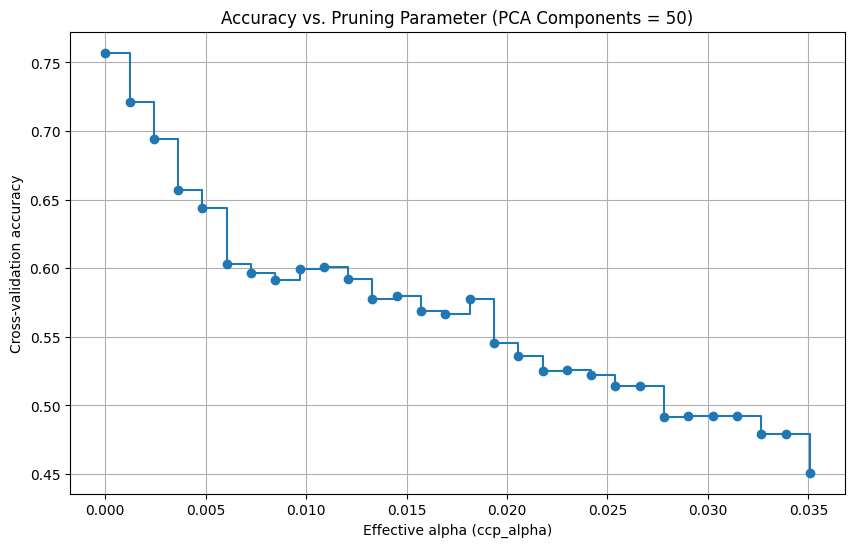


Evaluating the final pruned tree with 10-fold CV...
Pruned Decision Tree 10-fold CV accuracy: 0.9539


,model,ncomp,k,accuracy,best_alpha
0,DecisionTree_Pruned,50,None,0.953905,0.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_pruned_dt_experiment(X, y, ncomp=50):
    """
    Finds the optimal pruned Decision Tree and evaluates it,
    replicating the paper's methodology. (Faster Version)
    """
    results = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    print(f"Running Pruned Decision Tree experiment with {ncomp} PCA components...")

    # 1. Prepare the data
    Xp, _, _, _ = scale_pca(X, None, n_components=ncomp)

    # 2. Find the path of effective alphas for pruning
    clf = DecisionTreeClassifier(random_state=42)
    path = clf.cost_complexity_pruning_path(Xp, y)
    ccp_alphas = path.ccp_alphas
    ccp_alphas = ccp_alphas[:-1] # Exclude the trivial tree with just one node

    # 3. Use cross-validation to find the best alpha (FASTER METHOD)
    print("Finding optimal pruning parameter (ccp_alpha) via cross-validation...")
    alpha_scores = []

    # Create a smaller, evenly spaced grid of 30 alphas to test for speed
    alpha_grid = np.linspace(ccp_alphas.min(), ccp_alphas.max(), 30)

    for alpha in alpha_grid:
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
        score = cross_val_score(clf, Xp, y, cv=5, scoring='accuracy').mean()
        alpha_scores.append(score)

    best_alpha_index = np.argmax(alpha_scores)
    best_alpha = alpha_grid[best_alpha_index]
    print(f"Optimal ccp_alpha found: {best_alpha:.6f}")

    # Plot the accuracy vs alpha for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_grid, alpha_scores, marker='o', drawstyle="steps-post")
    plt.xlabel("Effective alpha (ccp_alpha)")
    plt.ylabel("Cross-validation accuracy")
    plt.title(f"Accuracy vs. Pruning Parameter (PCA Components = {ncomp})")
    plt.grid(True)
    plt.show()

    # 4. Evaluate the final, optimally pruned tree using 10-fold CV
    print("\nEvaluating the final pruned tree with 10-fold CV...")
    final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
    final_score = cross_val_score(final_clf, Xp, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    print(f"Pruned Decision Tree 10-fold CV accuracy: {final_score:.4f}")

    results.append({
        'model': 'DecisionTree_Pruned',
        'ncomp': ncomp,
        'k': None,
        'accuracy': final_score,
        'best_alpha': best_alpha
    })

    return pd.DataFrame(results)


# --- Run the experiment with 50 PCA components ---
df_pruned_dt_results_50 = run_pruned_dt_experiment(X_train_raw.values, y_train_floor, ncomp=50)

# Display the final result
display(df_pruned_dt_results_50)